In [1]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
#alternately, one could use unitary representations and normalization factors \sqrt{d_\rho/|G|}
#the resulting DFT will have signs \pm 1 on the diagonal DFT.DFT^* = S, which can be factored as s = rr^*, so S=RR^*
#again, uDFT = R^{-1}.DFT

In [24]:
#for u in GF(q), we can factor as u=aa^*=aa^q=a^{q+1} in GF(q**2) using gen. z and modular arithmetic
def conj_sqrt(u):
    if u == 0:
        return 0
    z = u.parent().multiplicative_generator()
    k = u.log(z)  # Compute discrete log of u to the base z
    if k % (q+1) != 0:
        raise ValueError("exponent must be divisible by q+1")
    return z ** (k//(q+1))

In [25]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
def unitary_dft():
    dft_matrix = SGA.dft()
    sign_diag = (dft_matrix*dft_matrix.H).diagonal()
    factor_diag_inv = diagonal_matrix([~conj_sqrt(d) for d in sign_diag])
    return factor_diag_inv*dft_matrix

In [139]:
#parameters and define the symmetric group algebra
n = 4; q = 7
F = GF(q**2)
SGA = SymmetricGroupAlgebra(F,n) # F[S_n], group algebra
assert F.characteristic() > 0, "F must have positive characteristic"
if not (F.is_field() and F.is_finite() and F.order().is_square()):
    raise ValueError("the base ring must be a finite field of square order")
if F.characteristic().divides(SGA.group().cardinality()):
    raise NotImplementedError("not implemented when p|n!; dimension of invariant forms may be greater than one")

In [140]:
#converting the unitary DFT over finite fields to a complex matrix using the root of unity map
U = unitary_dft(); U.str()

'[2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5 2*z2 + 5]\n[       1        1        4        4        4        4        6        6        3        3        3        3        3        3        4        4        0        0        3        3        4        4        0        0]\n[       0        0 2*z2 + 2 2*z2 + 2 3*z2 + 3 3*z2 + 3        0        0 2*z2 + 2 2*z2 + 2 3*z2 + 3 3*z2 + 3 5*z2 + 5 5*z2 + 5 5*z2 + 5 5*z2 + 5   z2 + 1   z2 + 1 4*z2 + 4 4*z2 + 4 4*z2 + 4 4*z2 + 4 6*z2 + 6 6*z2 + 6]\n[       0        0        0        0 6*z2 + 1 6*z2 + 1        0        0        0        0 6*z2 + 1 6*z2 + 1        0        0        0        0 6*z2 + 1 6*z2 + 1   z2 + 6   z2 + 6   z2 + 6   z2 + 6   z2 + 6   z2 + 6]\n[       0        0 5*z2 + 5 4*z2 + 4 5*z2 + 5 4*z2 + 4        0        0 2*z2 + 2 3*z2 + 3 2*z2 + 2 3*z2 + 3 5*z2 + 5 4*z2 

In [28]:
#check that U is unitary over a finite field. .H is conjugate-transpose
U*U.H == 1

True

In [141]:
#given a multiplicative generator `z` of the finite field, the discrete_log is the exponent of the generator
#the discrete_log of zero is -infinity, which we set to -1 for convenience since all other values are nonnegative
discrete_log = lambda F, x: x.log(F.multiplicative_generator()) if x != 0 else -1

In [142]:
#compute the discrete log of each entry of U
log_U = U.apply_map(lambda x: discrete_log(F,x))

In [143]:
log_U

24 x 24 dense matrix over Integer Ring (use the '.str()' method to see the entries)

In [185]:
"""
plot the discrete log of a matrix valued in a finite field
since log(0) = -infinity, we set this to -1, and color it black

- F is the field
- M is a matrix of discrete log values of elements of F

BUG: this is not working for large splitting fields, when the matrix values are ~7 digits
"""
def plot_discrete_log(F, M):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm

    cmap = plt.cm.hsv  # Get the HSV colormap
    num_colors = min(F.order(), 256) #for large fields we can't use that many colors, set a cutoff
    new_colors = np.vstack(([0, 0, 0, 1], cmap(np.linspace(0, 1, num_colors))))
    custom_cmap = ListedColormap(new_colors) # create a new custom colormap
    norm = BoundaryNorm([-1] + list(np.linspace(0, F.order()-1, num_colors)), custom_cmap.N) #map -1 to black

    # Plotting the data
    plt.imshow(M, cmap=custom_cmap, norm=norm, interpolation="nearest")
    plt.title(f"discrete log of uDFT of S_{n} over F_{q**2}", fontsize=16)
    plt.colorbar()
    plt.savefig(f"plots/dft_matrix/discrete_log_uDFT_n={n}_q={q**2}.png", dpi=300, bbox_inches="tight")
    plt.show()

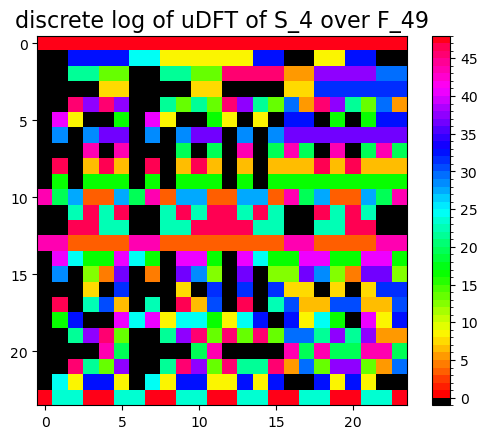

In [186]:
plot_discrete_log(F,log_U)

In [187]:
#the map from modular representation theory to compute Brauer characters from F_q --> \C giving roots of unity
#note: Brauer character is the rep'n matrix eigenvalues (over a splitting field extension of F_q) mapped to \C using Brauer map and summed
#i.e. let \alpha = g^k |--> \exp(2*pi*i*k/(q-1))
#i.e. F_q^* is cyclic of order q-1, mapping to (q-1)^th roots of unity in \C
brauer_map = lambda a, F: 0 if a == 0 else exp(2*pi*I*a.log(F.multiplicative_generator())/(F.order()-1))

In [188]:
#complexify the uDFT matrix over F_q using the Brauer map
U_complex = matrix(CC,U.apply_map(lambda a: brauer_map(a,F)))

In [189]:
#compute the Gram matrix, taking inner products of rows and columns w.r.t conjugate inner product
#note: want this to be the identity matrix (so it would be unitary over \C), but currently it is not quite
#unitary matrices are required if they are to be used as operators in quantum computing
gram = U_complex*U_complex.H

In [149]:
#function to round each component of a complex number 
def round_complex(z, digits):
    if z.imag_part():
        return round(z.real_part(), digits) + round(z.imag_part(), digits) * I
    return round(z, digits)

In [150]:
#round the (complex) Gram matrix to three decimal places
gram_rounded = gram.apply_map(lambda u:round_complex(u,3))

In [201]:
#plot the complexified version of the uDFT matrix over a finite field
def plot_arg_complex(U_complex, title):
    U_arg = U_complex.apply_map(lambda x: arg(x))  # find the argument of each element
    plot = matrix_plot(U_arg, cmap='hsv', colorbar=True, title=title)  # plot the matrix
    filename = "plots/dft_matrix/" + title.replace(" ", "_") + ".png"
    plot.save(filename, dpi=300)  # Save the plot as a PNG file with high resolution
    return plot

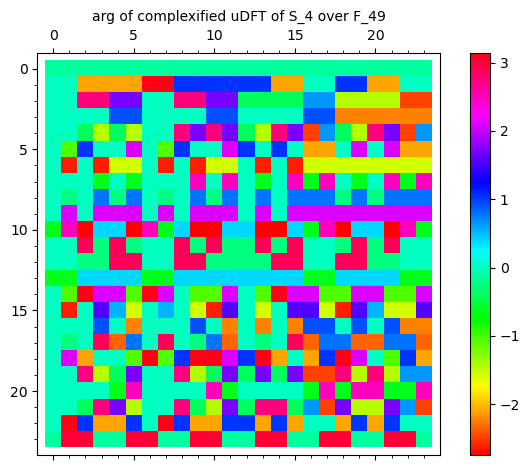

In [202]:
#plot the complexified version of the uDFT matrix over a finite field
plot_arg_complex(U_complex,title=f"arg of complexified uDFT of S_{n} over F_{q**2}")

In [173]:
#check that Gram matrix is conjugate symmetric (should be since it is U*U.H)
gram_rounded == gram_rounded.H

True

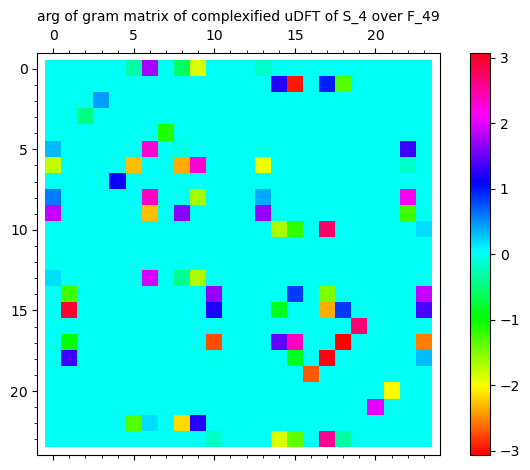

In [203]:
#plot the result of U_complex*U_complex.H to see how far it is from being unitary over the complex numbers
plot_arg_complex(gram_rounded, title=f"arg of gram matrix of complexified uDFT of S_{n} over F_{q**2}")

In [155]:
#compute the eigenvalues of the uDFT matrix
eigenvalues = U.eigenvalues(); eigenvalues

[6, 5*z2 + 3, 4*z14^13 + 6*z14^12 + 4*z14^11 + 5*z14^10 + 4*z14^8 + 3*z14^6 + 3*z14^5 + 5*z14^4 + z14^3 + 4*z14^2 + 4*z14 + 1, 2*z14^13 + z14^12 + 2*z14^11 + 5*z14^10 + 6*z14^8 + 2*z14^7 + 6*z14^6 + 5*z14^5 + 4*z14^4 + 3*z14^3 + 3*z14^2 + 4*z14 + 2, z14^13 + 2*z14^12 + 2*z14^11 + 4*z14^10 + 4*z14^9 + 2*z14^6 + z14^3 + 2*z14 + 3, z14^13 + 4*z14^12 + 3*z14^11 + 5*z14^10 + z14^9 + 5*z14^6 + 4*z14^5 + 5*z14^4 + 5*z14^3 + z14^2 + 5*z14 + 3, 3*z14^13 + 6*z14^12 + z14^11 + 3*z14^10 + 4*z14^9 + 6*z14^7 + 5*z14^6 + 3*z14^5 + 6*z14^4 + 2*z14^3 + 4*z14 + 5, 2*z14^13 + 2*z14^12 + z14^11 + 3*z14^9 + 3*z14^8 + 3*z14^7 + 5*z14^5 + 4*z14^4 + 2*z14^3 + 4*z14^2 + 4*z14 + 6, 6*z14^13 + 3*z14^12 + 6*z14^11 + 2*z14^9 + 4*z14^8 + 5*z14^6 + 4*z14^5 + z14^4 + 3*z14^3 + 3*z14^2, 6*z30^29 + 3*z30^28 + 6*z30^27 + 2*z30^25 + 3*z30^24 + 3*z30^23 + 5*z30^22 + 3*z30^21 + 4*z30^20 + 4*z30^19 + 2*z30^17 + 6*z30^16 + 4*z30^15 + 6*z30^14 + 4*z30^12 + 3*z30^11 + 4*z30^10 + 6*z30^9 + 6*z30^8 + 5*z30^7 + 5*z30^6 + 4*z30^5 

In [157]:
#compute the maximum degree required for the eigenvalues
#this should agree with the splitting field degree, but sometimes it doesn't
max_deg_eigs = max([eig.minpoly().degree() for eig in eigenvalues])

In [158]:
#compute the multiplicity of each eigenvalue. check if all eigenvalues are distinct
from collections import Counter
multiplicities = Counter(eigenvalues)
all_unique = all(count == 1 for count in multiplicities.values()); all_unique

True

In [159]:
#compute the charpoly of the uDFT matrix 
charpoly = U.minimal_polynomial(); charpoly

x^24 + z2*x^23 + (2*z2 + 2)*x^22 + (4*z2 + 4)*x^21 + (2*z2 + 6)*x^20 + 4*z2*x^19 + 2*z2*x^18 + (4*z2 + 3)*x^17 + (4*z2 + 6)*x^16 + (5*z2 + 2)*x^15 + 2*z2*x^14 + (6*z2 + 2)*x^13 + 5*z2*x^11 + (z2 + 5)*x^10 + (z2 + 1)*x^9 + z2*x^8 + (5*z2 + 5)*x^7 + (z2 + 5)*x^6 + (2*z2 + 3)*x^5 + 2*x^4 + (6*z2 + 1)*x^3 + (3*z2 + 4)*x^2 + (4*z2 + 6)*x + z2 + 3

In [160]:
#compute a splitting field of the characteristic polynomial
K = GF(q**max_deg_eigs); print(f"field containing all eigenvalues: K = {K}")
L = charpoly.splitting_field('a'); print(f"splitting field: L = {L}")
print(K.multiplicative_generator().minimal_polynomial())

field containing all eigenvalues: K = Finite Field in z30 of size 7^30
splitting field: L = Finite Field in a of size 7^210
x^30 + x^22 + 4*x^21 + 4*x^20 + x^19 + 4*x^18 + x^16 + 2*x^15 + 3*x^14 + 6*x^13 + 5*x^12 + 2*x^11 + 3*x^10 + 3*x^9 + 2*x^8 + 4*x^7 + 2*x^6 + 3*x^5 + x^3 + 5*x^2 + 2*x + 3


In [161]:
#compute the eigenvalues over a specific field K rather than using the algebraic closure
eigenvalues_K = matrix(K,U).eigenvalues(extend=False)

In [162]:
#compute the discrete log of the eigenvalues
log_eigenvalues = list(map(lambda x: discrete_log(K,x), eigenvalues_K)); log_eigenvalues

[11269670145346129043931624,
 19569211138526239672164486,
 20790904065162128909891334,
 6379196630969910098252790,
 424304164595145487956966,
 14087087681682661304914530,
 14785335754071908710154310,
 13690777798835597759922054,
 3222562647371267985937254,
 16861256861612106119861862,
 17207243712868805688146454,
 22520742049785640274165718,
 21628026486267985216684278,
 12239053578710904245803398,
 4483986111792702630829206,
 130187686346324695882710,
 9199351174957929468236070]

In [163]:
#compute the complexified eigenvalue
complex_eigenvalues = [brauer_map(eig,K) for eig in eigenvalues_K]

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Extract real and imaginary parts for plotting
real_parts = [eig.real() for eig in complex_eigenvalues]
imaginary_parts = [eig.imag() for eig in complex_eigenvalues]

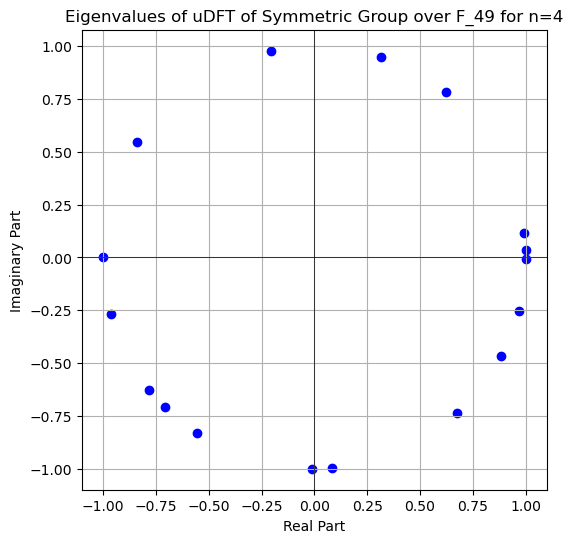

In [165]:
# Plotting the eigenvalues on the complex plane
plt.figure(figsize=(6,6))
plt.scatter(real_parts, imaginary_parts, color='blue', label="Eigenvalues")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Eigenvalues of uDFT of Symmetric Group over F_{q**2} for n={n}')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

In [166]:
#compute the eigenvectors over a splitting field
D, P = matrix(L,U).eigenmatrix_right()

In [179]:
def write_matrix_to_csv(P,filename):
    """
    dump the eigenvector matrix into a .csv file
    """
    with open(filename, "w") as f:
        for row in P:
            f.write(",".join(map(str, row)) + "\n")

In [180]:
write_matrix_to_csv(P,filename=f"data/eigenvectors_unitary_dft_symmetric_group_finite_field_n={n}_q={q}.csv")

In [174]:
#take the discrete log of the eigenvector matrix
log_P = P.apply_map(lambda x: discrete_log(L,x)); log_P

KeyboardInterrupt: 

In [169]:
#plot the discrete log of the eigenvector matrix P
plot_discrete_log(L,log_P)

ValueError: Maximum allowed size exceeded

In [175]:
def dump_discrete_log(L, P):
    """
    - compute the discrete log of each entry of P, the eigenvector matrix of the uDFT of S_n over F_{q^2}
    - write the resulting matrix to a comma separated value file
    - include a progress bar since computing discrete logs for large fields takes a long time
    """
    total = P.nrows() * P.ncols()
    count = 0
    filename = f"data/discrete_log_dft_symmetric_group_finite_field_eigenvector_matrix_n={n}_q={q}.csv"
    with open(filename, "w") as f:
        for i in range(P.nrows()):
            for j in range(P.ncols()):
                log_value = discrete_log(L, P[i, j])
                f.write(str(log_value))
                if j != P.ncols()-1:
                    f.write(",")
                count += 1
                # Print progress as a percentage
                progress = float(count) / total * 100
                print(f"Progress: {progress:.2f}%\n", end="")
            f.write("\n")
    return "done"

In [176]:
dump_discrete_log(L, P)

Progress: 0.17%
Progress: 0.35%
Progress: 0.52%
Progress: 0.69%
Progress: 0.87%
Progress: 1.04%
Progress: 1.22%
Progress: 1.39%
Progress: 1.56%
Progress: 1.74%
Progress: 1.91%
Progress: 2.08%


KeyboardInterrupt: 